In [3]:
import dynamax
import jax
import jax.numpy as jnp
import jax.random as jxr
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm

from jax.typing import ArrayLike

# GPLDS

(1, 1, 100)
[[95.7669]] [[145.06268]]


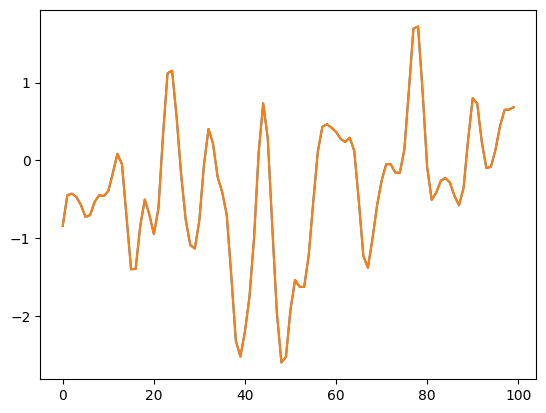

In [4]:
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalTriL as MVN_TL# from numpyro.distributions import MultivariateNormal as MVN

# kernel = lambda x,y : jnp.exp(-jnp.sum((x-y)**2)/2)

# def kernel_matrix(xs, ys):
#     kernel_fn = jax.vmap(lambda x: jax.vmap(lambda y: kernel(x, y))(ys))
#     return kernel_fn(xs)

@jax.jit
def squared_exponential_kernel(x1, x2, l=1.0, sigma=1.0):
    d = jnp.sum(jnp.square(x1 - x2))
    return sigma**2 * jnp.exp(-0.5 * d / l**2)

@jax.jit
def periodic_kernel(x1, x2, l=1.0, p=1.0, sigma=1.0):
    # d = jnp.sum(jnp.square(x1 - x2))
    d = jnp.abs(x1 - x2)
    return sigma**2 * jnp.exp(-2 * jnp.sin(jnp.pi * d / p)**2 / l**2)

def is_singular(K, tol=1e-3):
    return jnp.linalg.cond(K) > 1/tol

@jax.jit
def logprob_analytic(x: ArrayLike, mu: ArrayLike, cov: ArrayLike) -> float:
    '''
    Analytic log probability of a multivariate normal distribution. Handles singular covariance matrices.
    Args:
        x: Array, (N,)
        mu: Array, (N,)
        covar: Array, (N, N,)
    Returns:
        logprob: float
    '''
    N = x.shape[0]
    z = jnp.linalg.solve(cov, x - mu) # solve the linear system cov * z = x - mu
    _, logdetC = jnp.linalg.slogdet(cov)# + 1e-06 * jnp.eye(N))
    logprob = -(jnp.dot(x - mu, z) + logdetC + N * jnp.log(2.0 * jnp.pi)) / 2.0
    return logprob

class GaussianProcess:
    def __init__(self, kernel, D1, D2):
        self.kernel = kernel
        self.D1 = D1
        self.D2 = D2

    def evaluate_kernel(self, xs, ys):
        K = jax.vmap(lambda x: jax.vmap(lambda y: self.kernel(x,y))(ys))(xs)
        return K

    def joint(self, ts):
        T = ts.shape[0]
        m = jnp.zeros(T)
        K = self.evaluate_kernel(ts, ts)
        joint_dist = MVN(m, K)
        return joint_dist

    def sample(self, key, ts):
        '''
        Sample from the GP at the time points ts
        Returns:
            fs: Array, (D1, D2, T)
        '''
        # return self.joint(ts).sample(seed=key, sample_shape=(self.D1, self.D2))
        # return jax.random.multivariate_normal(key, jnp.zeros(ts.shape[0]), self.evaluate_kernel(ts, ts), shape=(self.D1, self.D2))
        return jax.random.multivariate_normal(key, mean=jnp.zeros(ts.shape[0]), cov=self.evaluate_kernel(ts, ts), method='svd', shape=(self.D1, self.D2))
    
    def log_prob(self, ts, fs, singular=True):
        '''
        Compute the log probability of the GP draws at the time points ts
        Args:
            ts: Array, (T,)
            fs: Array, (D1, D2, T)
        Returns:
            log_prob: Array, (D1, D2)
        '''
        K = self.evaluate_kernel(ts, ts)
        T = ts.shape[0]
        # if is_singular(K):    
        return jax.vmap(lambda _f: logprob_analytic(_f, jnp.zeros(T), K))(fs.reshape(self.D1*self.D2, T)).reshape(self.D1, self.D2)
        # # else:
        # return jax.scipy.stats.multivariate_normal.logpdf(fs, mean=jnp.zeros(T), cov=K)

# Test
key = jxr.PRNGKey(0)
kernel = lambda x,y: squared_exponential_kernel(x, y, 2.0, 1.0)
A_gp = GaussianProcess(kernel, 1, 1)

T = 100
ts = jnp.arange(T)

fs = A_gp.sample(jxr.PRNGKey(0), ts)

plt.plot(ts, fs[0,0,:])
plt.plot(ts, fs.transpose(2,1,0)[:,0,0])
print(fs.shape)

print(A_gp.log_prob(ts, fs), A_gp.log_prob(ts, jnp.zeros_like(fs)))

# print(fs)
# print(logprob_analytic(fs[0,0,:], jnp.zeros(T), A_gp.evaluate_kernel(ts, ts)))

# 2-D Torus example

In [5]:
# Constants
n_neurons = 10
latent_dim = 2
peaks = jnp.linspace(-jnp.pi, jnp.pi, n_neurons + 1)[:-1]  # tuning curve peaks
widths = 0.1 * jnp.ones(n_neurons)  # tuning curve widths
epsilon = 0.1
noise_scale = 0.05

In [6]:
@partial(jax.vmap, in_axes=(0, 0))
def dynamics(theta, omega):
    theta = (theta % (2 * jnp.pi)) - jnp.pi
    u = jnp.array([jnp.cos(theta), jnp.sin(theta)])
    v = jnp.array([-jnp.sin(theta), jnp.cos(theta)])
    A = (1 - epsilon) * v[:, None] * v[None, :]
    b = u + omega * v
    z = jnp.clip(theta - peaks, -jnp.pi * widths, jnp.pi * widths)
    C = (1 + jnp.cos(z / widths))[:, None] * (
        jnp.tile(u[None, :], (n_neurons, 1))
    )
    return (A, b, C)

def initial_condition(theta, omega):
    m0 = jnp.array([jnp.cos(theta), jnp.sin(theta)])
    S0 = noise_scale * jnp.eye(2)
    return (m0, S0)

def run_dynamics(key, As, bs, Cs, m0, S0):

    def f(x, inp):
        A, b, C, (subkey1, subkey2) = inp
        noise = noise_scale * (
            jxr.multivariate_normal(subkey1, jnp.zeros(2), jnp.eye(2))
        )
        x_next = A @ x + b + noise

        emission_noise = noise_scale * (
            jxr.multivariate_normal(subkey2, jnp.zeros(n_neurons), jnp.eye(n_neurons))
        )
        y_next = C @ x_next + emission_noise
        return x_next, (x_next, y_next)

    x_init = jxr.multivariate_normal(key, m0, S0)
    subkeys = jxr.split(key, num=(As.shape[0],2))
    return jax.lax.scan(f, x_init, xs=(As, bs, Cs, subkeys))

## Example trajectory and data

Text(0.5, 1.0, 'heading direction over time')

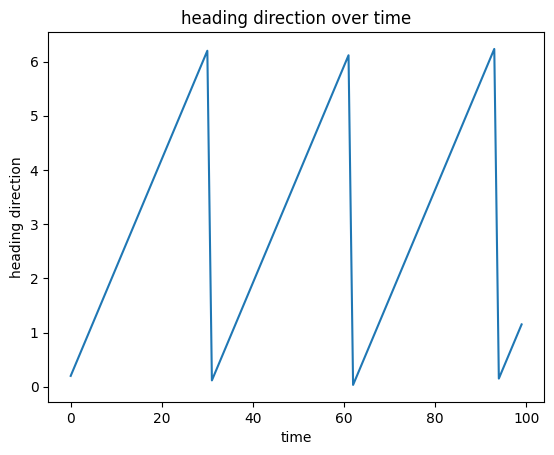

In [7]:
# Sample heading direction with constant velocity
num_timesteps = 100
speed = 0.2
omega = jnp.ones(num_timesteps) * speed
theta = jnp.cumsum(omega)

# Plot heading direction trajectory
plt.plot(theta % (2 * jnp.pi))
plt.ylabel('heading direction')
plt.xlabel('time')
plt.title('heading direction over time')

In [8]:
# Generate time-varying linear dynamics and initial condition
As, bs, Cs = dynamics(theta, omega)
m0, S0 = initial_condition(theta[0], omega[0])

# Translate to dynamax LG-SSM format
from dynamax.linear_gaussian_ssm.inference import make_lgssm_params
from dynamax.linear_gaussian_ssm import LinearGaussianSSM

true_params = make_lgssm_params(
    initial_mean=m0,
    initial_cov=S0,
    dynamics_weights=As,
    dynamics_cov=(noise_scale**2) * jnp.eye(latent_dim),
    dynamics_bias=bs,
    emissions_weights=Cs,
    emissions_cov=(noise_scale**2) * jnp.eye(n_neurons),
)
model = LinearGaussianSSM(state_dim=latent_dim, emission_dim=n_neurons, has_emissions_bias=False)

In [9]:
# Run the dynamics to get a batch of data
B = 100
X, Y = [], []
for i in tqdm(range(B), desc="Generating data"):
    # _, (xs, ys) = run_dynamics(jxr.PRNGKey(i), As, bs, Cs, m0, S0)
    xs, ys = model.sample(true_params, jxr.PRNGKey(i), num_timesteps)
    X.append(xs)
    Y.append(ys)

X = jnp.stack(X)
Y = jnp.stack(Y)

partition = int(0.8 * B)
X_train, Y_train = X[:partition], Y[:partition]
X_test, Y_test = X[partition:], Y[partition:]

Generating data: 100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


In [10]:
# Ensure that true params are indeed the MLE

_mll = lambda y: model.marginal_log_prob(true_params, y)
_Y_perturbed = Y + 0.1 * jxr.normal(jxr.PRNGKey(0), shape=Y.shape)

assert jax.vmap(_mll)(Y).mean() > jax.vmap(_mll)(_Y_perturbed).mean()

# Check that the gradient is zero around the MLE 

grads = []
B_range = jnp.arange(1, len(Y))[::20]
for i in B_range:
    print(i)
    def _log_lik(params):
        return jax.vmap(lambda y: model.marginal_log_prob(params, y), in_axes=0)(Y[:i]).mean()

    grad_log_lik = jax.grad(_log_lik)
    grads.append(grad_log_lik(true_params).initial.mean.flatten())

plt.plot(B_range, grads);

1
21
41
61


KeyboardInterrupt: 

In [ ]:
initial_mean_grads = []
for y in Y[::10]:
    _mll = lambda params: model.marginal_log_prob(params, y)
    _grad_mll = jax.grad(_mll)
    initial_mean_grads.append(_grad_mll(true_params).initial.mean.flatten())

initial_mean_grads = jnp.stack(initial_mean_grads)
def cummean(x):
    return jnp.cumsum(x) / jnp.arange(1, x.shape[0] + 1)

# for i in range(initial_mean_grads.shape[1]):
plt.plot(cummean(initial_mean_grads[:,0]))
plt.plot(cummean(initial_mean_grads[:,1]))

## Inference

In [ ]:
from jax.scipy.linalg import cho_factor, cho_solve

def symmetrize(A):
    """Symmetrize one or more matrices."""
    return 0.5 * (A + jnp.swapaxes(A, -1, -2))

def psd_solve(A, b, diagonal_boost=1e-9):
    """A wrapper for coordinating the linalg solvers used in the library for psd matrices."""
    A = symmetrize(A) + diagonal_boost * jnp.eye(A.shape[-1])
    L, lower = cho_factor(A, lower=True)
    x = cho_solve((L, lower), b)
    return x

@jax.jit
def marginal_log_prob(params, emissions):

    Q = params.dynamics.cov
    R = params.emissions.cov

    # Function for integrating out local latents (x)
    def _filter(carry, inputs):
        mu, V = carry
        A,b,C,y = inputs

        # Marginal lik filtering step (eq. 18) 
        y_pred = C @ mu
        S_pred = C @ V @ C.T + R

        ll = logprob_analytic(y, y_pred, S_pred)

        # Update step (eqs. 56-58)
        K = jnp.linalg.solve(S_pred, C @ V).T   # Kalman gain
        # K = psd_solve(S_pred, C @ V).T
        v = y - y_pred
        mu_post = mu + K @ v
        V_post = V - K @ S_pred @ K.T

        # Prediction step (eqs. 11-12)
        mu = A @ mu_post + b      
        V = A @ V_post @ A.T + Q

        return (mu, V), ll
    
    # y_pred_0 = params.emissions.weights[0] @ params.initial.mean
    # S_pred_0 = params.emissions.weights[0] @ params.initial.cov @ params.emissions.weights[0].T + R
    # ll0 = logprob_analytic(emissions[0], y_pred_0, S_pred_0)

    init = (params.initial.mean, params.initial.cov)
    inps = (params.dynamics.weights, params.dynamics.bias, params.emissions.weights, emissions)
    _, log_marginals = jax.lax.scan(_filter, init=init, xs=inps)
    return log_marginals.sum()

_y = Y_train[6]
print(model.marginal_log_prob(true_params, emissions=_y) - marginal_log_prob(true_params, emissions=_y))

In [ ]:
import optax
import sys
from jax.example_libraries import optimizers

# Define priors 

kernel = lambda x,y: periodic_kernel(x, y, l=1.0, p=2*jnp.pi, sigma=1.0)
gps = {
    'A': GaussianProcess(kernel, latent_dim, latent_dim),
    'b': GaussianProcess(kernel, latent_dim, 1),
    'C': GaussianProcess(kernel, n_neurons, latent_dim)
}

reg_coef = 1e-02 # Regularization coefficient, from kernel?

_marginal_log_prob = lambda params, emissions: marginal_log_prob(params, emissions)

# Optimize the weights with MLE

# Define loss function
# @jax.jit
def loss_fn(params):
    # Marginal emission likelihood
    log_py = jax.vmap(
        lambda y: _marginal_log_prob(params, emissions=y),
        in_axes=0, # vmap over batch dimension
    )(Y_train).sum()

    # Priors
    log_pA = gps['A'].log_prob(theta, params.dynamics.weights.transpose()).sum() # Sum over {i,j} iid entries
    log_pb = gps['b'].log_prob(theta, params.dynamics.bias.transpose()).sum()
    log_pC = gps['C'].log_prob(theta, params.emissions.weights.transpose()).sum()
    
    log_prob_joint = log_py + reg_coef * (log_pA + log_pb + log_pC)
    return -log_prob_joint


verbose = True
n_steps = 1000
tol = 1e-3
learning_rate = 1e-05

optimizer = optax.adam(learning_rate=learning_rate)
# opt_init, opt_update, get_params = optimizers.adam(1e-03)
# Exponential decay of the learning rate.
# scheduler = optax.exponential_decay(
#     init_value=1e-03,
#     transition_steps=500,
#     decay_rate=0.5, # Decay by `decay_rate` every `transition_steps` steps.
#     )
# # Combining gradient transforms using `optax.chain`.
# optimizer = optax.chain(
# #     optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
#     optax.scale_by_adam(),  # Use the updates from adam.
#     optax.scale_by_learning_rate(1e-05),
# #     optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
# #     # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
#     optax.scale(-1.0)
# )
   
params = make_lgssm_params(
    initial_mean=m0,
    initial_cov=S0,
    dynamics_weights=gps['A'].sample(jxr.PRNGKey(1), theta).transpose(2,0,1),
    dynamics_bias=bs, #gps['b'].sample(jxr.PRNGKey(0), theta).squeeze().transpose(),
    dynamics_cov=(noise_scale**2) * jnp.eye(latent_dim),
    emissions_weights=Cs, #gps['C'].sample(jxr.PRNGKey(0), theta).transpose(2,0,1),
    emissions_cov=(noise_scale**2) * jnp.eye(n_neurons),
)

# params = initial_params
opt_state = optimizer.init(params)
# opt_state = opt_init(params)

# @jax.jit
# def step(i, opt_state):
#     params = get_params(opt_state)
#     g = jax.grad(loss_fn)(params)
#     return opt_update(i, g, opt_state)

# @jax.jit
def step(params, opt_state):
    val, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, val


def rdiff(a, b):
    return jnp.abs(a - b) / max(jnp.abs(a), jnp.abs(b))

losses = []
train_mlls = []
test_mlls = []
prior_A_logprobs = []
prior_b_logprobs = []
prior_C_logprobs = []

# pbar = tqdm(jnp.arange(n_steps), desc='Training')
for i in jnp.arange(n_steps):
    # opt_state = step(i, opt_state)
    # params = get_params(opt_state)

    # grads = jax.grad(loss_fn)(params)
    # updates, opt_state = optimizer.update(grads, opt_state)
    # params = optax.apply_updates(params, updates)

    # loss_before_update = loss_fn(params)
    params, opt_state, loss = step(params, opt_state)
    # loss_after_update = loss_fn(params)
    # print(loss_before_update, loss_after_update, loss_before_update - loss_after_update)

    losses.append(loss)

    if i % 10 == 0:
        # pbar.update(10)
        # pbar.set_postfix_str(f"Loss = {log_joints[-1]:.2e}")  
        if verbose:
            print(f"[{i}] loss = {losses[-1]:.2e}")
            if i > 0:
                print(f"\tLoss change: {losses[-1] - losses[-2]:.2e}, rdiff: {rdiff(losses[-1], losses[-2]):.2e}")
        
        # Evaluate on test set and compare marginal log liks
        _mll_func = lambda y: _marginal_log_prob(params, emissions=y)
        
        train_mll = jax.vmap(_mll_func, in_axes=0)(Y_train).mean()
        train_mlls.append(train_mll)
        
        test_mll = jax.vmap(_mll_func, in_axes=0)(Y_test).mean()
        test_mlls.append(test_mll)
        if verbose:
            print(f"\tMLL: train = {train_mll:.2e}, test = {test_mll:.2e}")

        prior_A_logprob = gps['A'].log_prob(theta, params.dynamics.weights.transpose()).sum()
        prior_b_logprob = gps['b'].log_prob(theta, params.dynamics.bias.transpose()).sum()
        prior_C_logprob = gps['C'].log_prob(theta, params.emissions.weights.transpose()).sum()
        prior_A_logprobs.append(prior_A_logprob)
        prior_b_logprobs.append(prior_b_logprob)
        prior_C_logprobs.append(prior_C_logprob)
        if verbose:
            print(f"\tPrior log probs: A = {prior_A_logprob:.2e}, b = {prior_b_logprob:.2e}, C = {prior_C_logprob:.2e}")

        
    # # Add stopping condition based on log liks 
    # if i > 10 and jnp.isclose(log_joints[-1], jnp.array(log_joints[-10:-1]).mean(), rtol=tol):
    #     print(f'[{i}] Stopping training early. Log likelihood change: {log_joints[-1] - log_joints[-2]:.2e}, final log likelihood: {log_joints[-1]:.2e}')
    #     break

    if jnp.isnan(losses[-1]):
        print(f'[{i}] NaN loss. Exiting training.')
        break

fig, axs = plt.subplots(ncols=3, figsize=(10,3), constrained_layout=True)
axs[0].plot(losses)
# axs[0].set_yscale('log')
axs[0].set_title('Loss (negative log joint)')

axs[1].plot(train_mlls, label='train')
axs[1].plot(test_mlls, label='test')
axs[1].set_title('Marginal Log Likelihood')

axs[2].plot(prior_A_logprobs, label='prior A')
axs[2].plot(prior_b_logprobs, label='prior b')
axs[2].plot(prior_C_logprobs, label='prior C')
axs[2].set_title('Prior log probs')

axs[1].legend()
plt.show()

In [ ]:
p_kernel = lambda x,y: periodic_kernel(x, y, l=1.0, p=2*jnp.pi, sigma=100.0)
gp = GaussianProcess(p_kernel, 1, 1)
for i in range(10):
    plt.plot(gp.sample(jxr.PRNGKey(i), theta).flatten(), c='r', alpha=0.3)

In [ ]:
# # Plot vector fields of the dynamics

# x_range = jnp.linspace(-2, 2, 10)

# def vector_field(A, x_range):
#     X, Y = jnp.meshgrid(x_range, x_range)
#     points = jnp.stack([X, Y], axis=-1)
#     transformed_points = jax.vmap(jax.vmap(lambda point: jnp.dot(A, point)))(points)
#     U = transformed_points[..., 0] - points[..., 0]
#     V = transformed_points[..., 1] - points[..., 1]
#     return U, V

# U, V = vector_field(As[40], x_range)

# # Plot the vector field
# fig, ax = plt.subplots()
# ax.quiver(X, Y, U.squeeze(), V.squeeze())
# ax.set_aspect('equal')
# ax.set_xlim(-2, 2)

In [ ]:
kernel = lambda x,y: periodic_kernel(x, y, l=1.0, p=2*jnp.pi, sigma=1.0)
gps = {
    'A': GaussianProcess(kernel, latent_dim, latent_dim),
    'b': GaussianProcess(kernel, latent_dim, 1),
    'C': GaussianProcess(kernel, n_neurons, latent_dim)
}

plt.plot(As[:,0,0])
plt.plot(params.dynamics.weights[:,0,0])

print(gps['A'].log_prob(theta, params.dynamics.weights.transpose()).sum())
print(gps['A'].log_prob(theta, As.transpose(2,1,0)).sum())

In [ ]:
colors = ['tab:blue', 'tab:orange']
for i in [0,1]:
    # plt.plot(X_train[0,:,i], color=colors[i], ls='-')
    plt.plot(model.smoother(true_params, Y_train[0]).smoothed_means[:,i], color=colors[i], ls='-')
    plt.plot(model.smoother(params, Y_train[0]).smoothed_means[:,i], color=colors[i], ls='--')
    # plt.fill_between(
    #     jnp.arange(num_timesteps),
    #     model.smoother(params, Y[0]).smoothed_means[:,i] - 2 * jnp.sqrt(model.smoother(params, Y[0]).smoothed_covariances[:,i,i]),
    #     model.smoother(params, Y[0]).smoothed_means[:,i] + 2 * jnp.sqrt(model.smoother(params, Y[0]).smoothed_covariances[:,i,i]),
    #     color=colors[i],
    #     alpha=0.3
    # )

In [ ]:
model.smoother(params, Y_train[0])

# Weight space inference

There is hope to do closed-form inference. As least in the one dimensional setting there may be a way forward, let's try. 

In [11]:
def basis_func(m, type='sin'):
    if type == 'sin':
        return lambda x: jnp.sqrt(2) * jnp.sin(m * 2 * jnp.pi * x)
    elif type == 'cos':
        return lambda x: jnp.sqrt(2) * jnp.cos(m * 2 * jnp.pi * x)
    elif type == 'const':
        return lambda x: 1
    else:
        raise ValueError(f"Unknown basis function type: {type}")

def basis_func2d(m, n, type='sin'):
    if type == 'sin':
        return lambda x_1, x_2: jnp.sin(m * 2* jnp.pi * x_1 + n * 2* jnp.pi * x_2)
    elif type == 'cos':
        return lambda x_1, x_2: jnp.cos(m * 2* jnp.pi * x_1 + n * 2* jnp.pi * x_2)
    elif type == 'const':
        return lambda x_1, x_2: 1 / (2*jnp.pi)
    else:
        raise ValueError(f"Unknown basis function type: {type}")
    
def basis(N, dim=1):
    '''return the const function, and the sin and cos functions to constitute a basis of length N (rounded down to the nearest odd number)'''
    basis_funcs = []
    if dim == 1:
        basis_funcs.append(basis_func(0, 'const'))
    else:
        basis_funcs.append(basis_func2d(0, 0, 'const'))
    if N > 1:
        for n in range(1, int(N/2)+1):
            if dim == 1:
                basis_funcs.append(basis_func(n, 'sin'))
                basis_funcs.append(basis_func(n, 'cos'))
            else:
                basis_funcs.append(basis_func2d(0, n, 'cos'))
                basis_funcs.append(basis_func2d(0, n, 'sin')) #! add m part
    assert len(basis_funcs) == N - N%2 + 1, len(basis_funcs)
    return basis_funcs

def evaluate_basis(basis_funcs, x):
    '''evaluate the basis functions at the given point'''
    return jnp.array([f(x) for f in basis_funcs])

def basis_matrix(basis_funcs, X):
    '''
    Return matrix of basis function evaluations at the given points
    Args:
        basis_funcs: list of basis functions
        X: Array, shape (n, d)
    Returns:
        Phi: Array, shape (n, len(basis_funcs))
    '''
    Phi = jnp.array([evaluate_basis(basis_funcs, x) for x in X])
    return Phi

def test_basis_orthonormality():
    theta_range = jnp.linspace(0, 1, 1000)
    dtheta = theta_range[1] - theta_range[0]
    basis_funcs = basis(5)
    Phi = basis_matrix(basis_funcs, theta_range)
    assert jnp.allclose((Phi.T @ Phi) * dtheta, jnp.eye(5), atol=1e-2)

test_basis_orthonormality()

In [12]:
def w_MAP_estimate(X, Y, basis_funcs, alpha=1e-3):
    '''
    Compute the MAP estimate of the weights of the basis functions
    Args:
        X: Array, shape (n, d)
        Y: Array, shape (n,)
        basis_funcs: list of basis functions
        alpha: float, regularization parameter
    Returns:
        w_MAP: Array, shape (len(basis_funcs),)
    '''
    Phi = basis_matrix(basis_funcs, X)
    print(Phi.shape)
    w_MAP = jnp.linalg.solve(Phi.T @ Phi + alpha * jnp.eye(len(basis_funcs)), Phi.T @ Y)
    return w_MAP

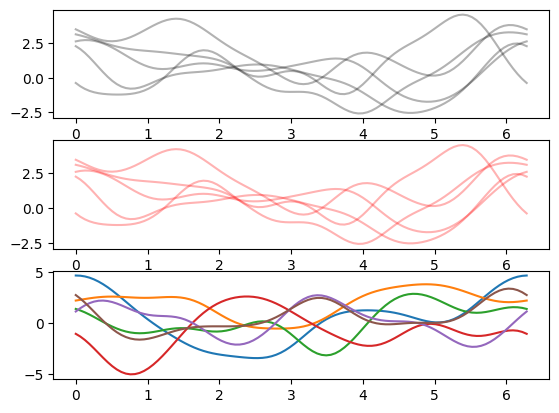

In [13]:
def torus_basis(N, sigma, kappa, period=1.0):
    '''Returns N basis functions for a torus manifold'''
    def weight_space_coefficients(sigma, kappa, m):
        return sigma * jnp.sqrt(jnp.exp(- 2* jnp.pi**2 * kappa**2 * m**2))
    
    basis_funcs = [] #[lambda x: weight_space_coefficients(sigma, kappa, 0) / period * jnp.ones_like(x)] # constant function
    for n in jnp.arange(-N, N):
        # if n == 0:
        #     continue
        def _f_sin(x, n=n): # make sure to add n=n to avoid late binding
            return weight_space_coefficients(sigma, kappa, n) * jnp.sin(n * 2*jnp.pi * x / period)
        def _f_cos(x, n=n):
            return weight_space_coefficients(sigma, kappa, n) * jnp.cos(n * 2*jnp.pi * x / period)
        basis_funcs.append(_f_sin)
        basis_funcs.append(_f_cos)

    # for n in range(1, int(N/2)+1):
    #     def _f_sin(x, n=n): # make sure to add n=n to avoid late binding
    #         return weight_space_coefficients(sigma, kappa, n) * jnp.sin(n * 2*jnp.pi * x / period)
    #     def _f_cos(x, n=n):
    #         return weight_space_coefficients(sigma, kappa, n) * jnp.cos(n * 2*jnp.pi * x / period)
    #     basis_funcs.append(_f_sin)
    #     basis_funcs.append(_f_cos)
    assert len(basis_funcs) == 4*N, len(basis_funcs)
    return basis_funcs

class WeightSpaceFunc():
    def __init__(self, weights, basis_funcs):
        '''
        Args:
            weights: Array, (D1, D2, K)
            basis_funcs: list of basis functions, length K
        '''
        self.weights = weights
        self.basis_funcs = basis_funcs

    def __call__(self, c):
        '''
        Args:
            x: Array, (T,)
        Returns:
            f: Array, (T, D1, D2)
        '''
        Phi = jnp.array([f(c) for f in self.basis_funcs]).T # shape (N, K)
        return jnp.dot(Phi, self.weights)

class WeightSpaceGP():
    '''
    Weight-space Gaussian Process prior
    '''
    def __init__(self, sigma, kappa, N, period=1.0, manifold='torus'):
        # Set hyperparameters
        self.sigma = sigma
        self.kappa = kappa
        self.N = N
        assert N > 0
        self.period = period
        self.manifold = manifold
        
        # Construct basis functions
        self.basis_funcs = torus_basis(N=N, sigma=sigma, kappa=kappa, period=period) # Basis length is 4N - 1

    def sample(self, key, xs, D1=1, D2=1):
        # f = jnp.zeros_like(xs)
        # weights = []
        # for n in jnp.arange(-self.N, self.N):
        #     key, subkey1, subkey2 = jxr.split(key, num=3)
        #     # f += jxr.normal(subkey1) * weight_space_coefficients(self.sigma, self.kappa, n) * jnp.sin(n * 2*jnp.pi * xs)
        #     # f += jxr.normal(subkey2) * weight_space_coefficients(self.sigma, self.kappa, n) * jnp.cos(n * 2*jnp.pi * xs)
        #     weights.append(jxr.normal(subkey1))
        #     weights.append(jxr.normal(subkey2))
        # weights = jnp.array(weights)

        # As = []
        # for i in range(D1*D2):
        #     key, subkey = jxr.split(key)
        #     weights = jxr.normal(subkey, shape=(len(self.basis_funcs),))
        #     A_func = WeightSpaceFunc(weights, self.basis_funcs)
        #     As.append(A_func(xs))
        # return jnp.stack(As).reshape(D1, D2, len(xs)).transpose(2,0,1)

        weights = self.weights(key, D1, D2) # Shape (D1, D2, K)
        Phi = self.evaluate_basis(xs) # Shape (len(xs), K)
        A_evals = jnp.einsum('ijk,lk->lij', weights, Phi)
        return A_evals
    
    def weights(self, key, D1=1, D2=1):
        # weights = []
        # for i in range(D1*D2):
        #     key, subkey = jxr.split(key)
        #     _weights = jxr.normal(subkey, shape=(len(self.basis_funcs),))
        #     weights.append(_weights)
        # return jnp.array(weights).reshape(D1, D2, len(self.basis_funcs))
        return jxr.normal(key, shape=(D1, D2, len(self.basis_funcs)))
    
    def evaluate_basis(self, x):
        '''
        Evaluate the basis functions at X
        Args:
            X: Array, (T,)
        Returns:
            Phi: Array, (T, K)
        '''
        return jnp.array([f(x) for f in self.basis_funcs]).T
    
    def log_prob(self, xs, fs):
        '''
        Compute the log probability of the GP draws at the time points ts
        Args:
            ts: Array, (T,)
            fs: Array, (T, D1, D2)
        Returns:
            log_prob: Array, (D1, D2)
        '''
        Phi = self.evaluate_basis(xs)
        K = jnp.dot(Phi, Phi.T)
        T = len(fs)
        return logprob_analytic(fs, jnp.zeros(T), K)

period = 2*jnp.pi
theta_range = jnp.linspace(0, period, 100)
gp = WeightSpaceGP(1.0, 0.1, N=11, period=period)
fig, axs = plt.subplots(nrows=3)

key = jxr.PRNGKey(0)
for i in range(5):
    key, subkey = jxr.split(key)
    sample = gp.sample(key, theta_range)
    # assert gp.log_prob(theta_range, gp.sample(jxr.PRNGKey(0), theta_range)) < gp.log_prob(theta_range, jnp.zeros_like(theta_range))
    axs[0].plot(theta_range, sample[:,0,0], c='k', alpha=0.3)

    sample_2 = WeightSpaceFunc(gp.weights(key).squeeze(), gp.basis_funcs)(theta_range)
    axs[1].plot(theta_range, sample_2, c='r', alpha=0.3)

high_dim_sample = gp.sample(jxr.PRNGKey(0), theta_range, D1=3, D2=2)
axs[2].plot(theta_range, high_dim_sample.reshape(len(theta_range), -1));

(100, 32)
(100, 32)
(100, 32)


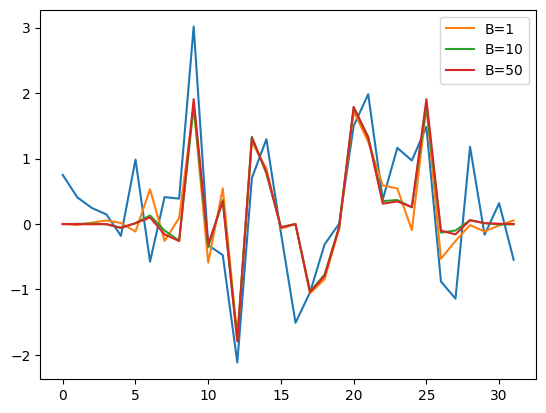

In [14]:
true_key = jxr.PRNGKey(1)
theta_range = jnp.linspace(0, 1, 100)
gp = WeightSpaceGP(1.0, 0.1, N=8)
gp_draw = gp.sample(true_key, theta_range).squeeze()

# Add noise to the GP draw, make 10 repeats

plt.plot(gp.weights(true_key).squeeze())
for B in [1,10,50]:
    ys = gp_draw[..., None] + jxr.normal(key=jxr.PRNGKey(44), shape=(*gp_draw.shape, B))
    w_MAP = w_MAP_estimate(theta_range, ys, gp.basis_funcs, alpha=1.0)
    plt.plot(w_MAP.mean(axis=1), label=f'B={B}')
plt.legend()

### 1d example

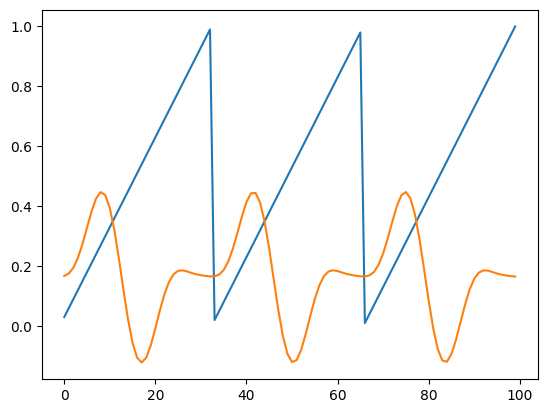

In [25]:
# Generate random GP-LDS dynamics

# Constants
T = 100
theta = jnp.cumsum(jnp.ones(T) * 0.03) % 1
latent_dim = 1
n_neurons = 10
plt.plot(theta)

# Params
A_prior = WeightSpaceGP(0.5, 0.2, N=10)
noise_scale = 0.1
true_key = jxr.PRNGKey(0)
m0 = jnp.zeros(latent_dim)
S0 = jnp.eye(latent_dim)
As = A_prior.sample(true_key, theta)
plt.plot(As[:,0,0])

# Translate to dynamax LG-SSM format
from dynamax.linear_gaussian_ssm.inference import make_lgssm_params
from dynamax.linear_gaussian_ssm import LinearGaussianSSM

# true_params = make_lgssm_params(
#     initial_mean=m0,
#     initial_cov=S0,
#     dynamics_weights=As,
#     dynamics_cov=(noise_scale**2) * jnp.eye(latent_dim),
#     emissions_weights=jnp.ones((n_neurons, latent_dim)),
#     emissions_cov=(noise_scale**2) * jnp.eye(n_neurons),
# )
model = LinearGaussianSSM(state_dim=latent_dim, emission_dim=n_neurons, has_emissions_bias=False, has_dynamics_bias=False)
true_params, true_params_props = model.initialize(
    initial_mean=m0, 
    initial_covariance=S0, 
    dynamics_weights=As,
    dynamics_covariance=(noise_scale**2) * jnp.eye(latent_dim),
    emission_weights=jnp.ones((n_neurons, latent_dim)),
    emission_covariance=(noise_scale**2) * jnp.eye(n_neurons),
)

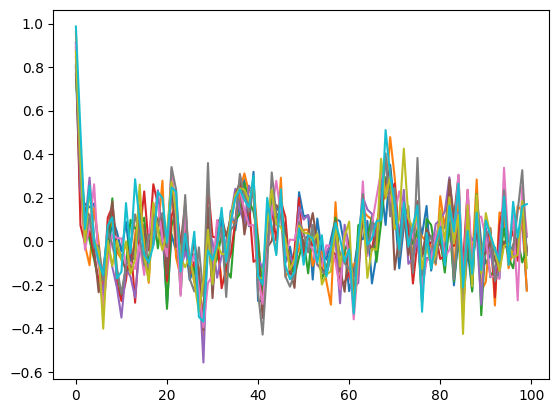

In [30]:
B = 100
def func(i):
    xs, ys = model.sample(true_params, jxr.PRNGKey(i), num_timesteps)
    return xs, ys
X, Y = jax.vmap(func)(jnp.arange(B))

plt.plot(Y[0]);

In [31]:
# At true params, compute MAP estimate

w_MAP = jnp.zeros((len(A_prior.basis_funcs),))
def _func(i):
    x_map = model.smoother(true_params, Y[i]).smoothed_means.squeeze()
    fs = x_map[1:]
    xs = jnp.multiply(evaluate_basis(A_prior.basis_funcs, theta[:-1]), x_map[:-1]).T
    return xs, fs

_X, _F = jax.vmap(_func)(jnp.arange(B))
_X = jnp.concatenate(_X)
_F = jnp.concatenate(_F)
w_MAP = jnp.linalg.solve(_X.T @ _X + 1.0 * jnp.eye(len(A_prior.basis_funcs)), _X.T @ _F)

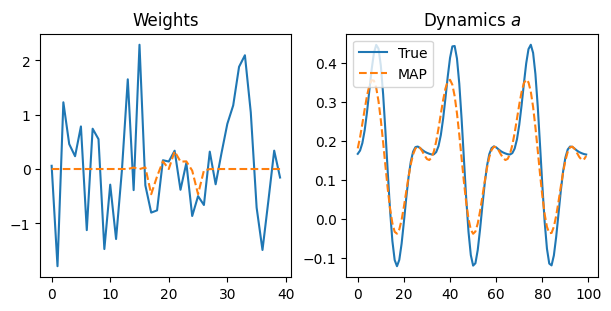

In [32]:
fig, axs = plt.subplots(ncols=2, figsize=(6,3), constrained_layout=True)
axs[0].plot(A_prior.weights(true_key).squeeze(), c='tab:blue', label='True')
axs[0].plot(w_MAP, c='tab:orange', ls='--')
axs[0].set_title('Weights')

axs[1].plot(As.squeeze(), c='tab:blue', label='True')
axs[1].plot(w_MAP @ evaluate_basis(A_prior.basis_funcs, theta), c='tab:orange', ls='--', label='MAP')
axs[1].set_title('Dynamics $a$')
axs[1].legend()

## EM

### Naive EM with delta E-step

EM Training: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]

Marginal log probs:  [726.8108520507812, 762.6602783203125, 763.3079223632812, 763.3331298828125, 763.3356323242188, 763.3359375, 763.3359375, 763.3359375, 763.3359985351562, 763.3359985351562]


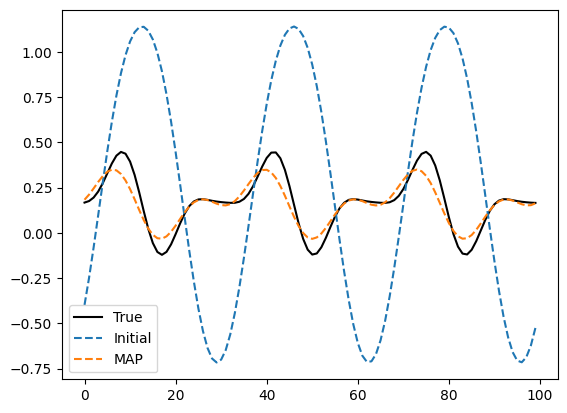

In [33]:
Phi = evaluate_basis(A_prior.basis_funcs, theta[:-1])
def step(params):
    # E-step
    def _get_sufficient_stats(i):
        x_map = model.smoother(params, Y[i]).smoothed_means.squeeze()
        xs = jnp.multiply(Phi, x_map[:-1]).T
        fs = x_map[1:]
        return xs, fs

    _X, _F = jax.vmap(_get_sufficient_stats)(jnp.arange(B))
    _X = jnp.concatenate(_X)
    _F = jnp.concatenate(_F)

    # M-step : compute MAP estimate as penalised least squares solution
    w_MAP = jnp.linalg.solve(_X.T @ _X + 1.0 * jnp.eye(len(A_prior.basis_funcs)), _X.T @ _F)

    # Update the dynamics weights
    As_MAP = w_MAP @ evaluate_basis(A_prior.basis_funcs, theta)

    out_params = make_lgssm_params(
        initial_mean=m0,
        initial_cov=S0,
        dynamics_weights=As_MAP.reshape(-1,1,1),
        dynamics_cov=(noise_scale**2) * jnp.eye(latent_dim),
        emissions_weights=jnp.ones((n_neurons, latent_dim)),
        emissions_cov=(noise_scale**2) * jnp.eye(n_neurons),
    )
    return out_params

initial_params = make_lgssm_params(
        initial_mean=m0,
        initial_cov=S0,
        dynamics_weights=A_prior.sample(jxr.PRNGKey(3), theta).reshape(-1,1,1),
        dynamics_cov=(noise_scale**2) * jnp.eye(latent_dim),
        emissions_weights=jnp.ones((n_neurons, latent_dim)),
        emissions_cov=(noise_scale**2) * jnp.eye(n_neurons),
    )

plt.plot(As.squeeze(), c='k', label='True')
plt.plot(initial_params.dynamics.weights.squeeze(), c='tab:blue', ls='--', label='Initial')
params = initial_params
mlls = []
for i in tqdm(range(10), desc='EM Training'):
    mll = jax.vmap(lambda y: model.marginal_log_prob(params, y))(Y).mean()
    mlls.append(mll.item())
    params = step(params)
plt.plot(params.dynamics.weights.squeeze(), c='tab:orange', ls='--', label='MAP')
plt.legend()

print('Marginal log probs: ', mlls)

In [ ]:
# Compare with gradient ascent

reg_coef = 1.0
def loss_fn(params):
    # Marginal emission likelihood
    log_py = jax.vmap(
        lambda y: model.marginal_log_prob(params, emissions=y),
    )(Y).sum()

    # Priors
    log_pA = A_prior.log_prob(theta, params.dynamics.weights.squeeze())
    
    log_prob_joint = log_py + reg_coef * log_pA
    return -log_prob_joint

optimizer = optax.adam(learning_rate=1e-03)

def step(params, opt_state):
    val, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, val

initial_params = make_lgssm_params(
        initial_mean=m0,
        initial_cov=S0,
        dynamics_weights=A_prior.sample(jxr.PRNGKey(3), theta).reshape(-1,1,1),
        dynamics_cov=(noise_scale**2) * jnp.eye(latent_dim),
        emissions_weights=jnp.ones((n_neurons, latent_dim)),
        emissions_cov=(noise_scale**2) * jnp.eye(n_neurons),
    )
params = initial_params
opt_state = optimizer.init(params)

n_steps = 1000
losses = []
for i in jnp.arange(n_steps):
    params, opt_state, loss = step(params, opt_state)

    losses.append(loss)
    if i % 10 == 0:
        print(f"[{i}] loss = {loss:.2e}")

    # Running average stopping condition
    if i > 10 and jnp.isclose(losses[-1], jnp.array(losses[-10:-1]).mean(), rtol=1e-3):
        print(f'[{i}] Stopping training early. Log likelihood change: {losses[-1] - losses[-2]:.2e}, final log likelihood: {losses[-1]:.2e}')
        break

    if jnp.isnan(losses[-1]):
        print(f'[{i}] NaN loss. Exiting training.')
        break

    

# Plot results

plt.plot(As.squeeze(), c='k', label='True')
plt.plot(initial_params.dynamics.weights.squeeze(), c='tab:blue', ls='--', label='Initial')
plt.plot(params.dynamics.weights.squeeze(), c='tab:orange', ls='--', label='MAP')
plt.legend()

### EM with full updates

In [ ]:
# Define summary statistics, can all be obtained from the smoothed means and covariances

def M_t1t2(t1, t2, smoothed_means, smoothed_covs):
    out = []
    for t in range(t1, t2):
        out.append(smoothed_means[t] @ smoothed_means[t].T + smoothed_covs[t])
    return jnp.stack(out).sum(axis=0)

def M_delta(smoothed_means, smoothed_cross_covariances):
    out = []
    for t in range(2, len(smoothed_means)):
        out.append(smoothed_means[t-1] @ smoothed_means[t].T + smoothed_cross_covariances[t-1])
    return jnp.stack(out).sum(axis=0)

def Y_summarystat(Y):
    return Y @ Y.T

def tildeY_summarystat(Y, smoothed_means):
    return Y @ smoothed_means.T

In [35]:
def linreg(X, Y, reg_coef=1e-3):
    r'''
    Returns MAP estimate of the weights `w` for the system Y = Xw + noise
    Args:
        X: Array, shape (N, D)
        Y: Array, shape (N, M)
        reg_coef: float, regularization coefficient
    Returns:
        w_MAP: Array, shape (D, M)
    '''
    w_MAP = jax.scipy.linalg.solve(X.T @ X + reg_coef * jnp.eye(X.shape[1]), X.T @ Y)
    assert w_MAP.shape == (X.shape[1], Y.shape[1])
    return w_MAP

def weight_space_linreg(X, Y, basis_funcs, theta):
    r'''
    Returns MAP estimate of the weights `w` for the system
        Y = A X + noise
    with a GP prior on A of the form
        A_{ij}(theta) = \sum_k w^{(ij)} \phi_k(theta)
    with basis functions \phi_k and weights w^{(ij)} ~ N(0, 1).

    Args:
        X: Array, shape (N, D). Regressors, N samples, D features
        Y: Array, shape (N, M). Targets, N samples, M features
        basis_funcs: list of basis functions
        theta: Array, shape (N,)
    Returns:
        w_MAP: Array, shape (M, D, K)
    '''
    Phi = jnp.array([f(theta) for f in basis_funcs]).T # shape (N, K)
    K = len(basis_funcs)
    M, D = Y.shape[1], X.shape[1]

    # Phi_X = jnp.multiply(Phi[:, jnp.newaxis, :], X[:, :, jnp.newaxis])
    # Phi_X = Phi_X.reshape(N, D * K)
    Phi_X = jax.vmap(lambda Phi_n, X_n: jnp.kron(Phi_n, X_n))(Phi, X)

    W_MAP = linreg(Phi_X, Y, reg_coef=1.0).reshape(K, D, M)
    W_MAP = W_MAP.transpose(2, 1, 0)
    assert W_MAP.shape == (M, D, K)
    return W_MAP

In [36]:
from fastprogress.fastprogress import progress_bar
from functools import partial
from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import tree_map
from jaxtyping import Array, Float, PyTree
import tensorflow_probability.substrates.jax.distributions as tfd
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
from typing import Any, Optional, Tuple, Union
from typing_extensions import Protocol

from dynamax.ssm import SSM
from dynamax.linear_gaussian_ssm.inference import lgssm_joint_sample, lgssm_filter, lgssm_smoother, lgssm_posterior_sample
from dynamax.linear_gaussian_ssm.inference import ParamsLGSSM, ParamsLGSSMInitial, ParamsLGSSMDynamics, ParamsLGSSMEmissions
from dynamax.linear_gaussian_ssm.models import SuffStatsLGSSM
from dynamax.linear_gaussian_ssm.inference import PosteriorGSSMFiltered, PosteriorGSSMSmoothed
from dynamax.parameters import ParameterProperties, ParameterSet
from dynamax.types import PRNGKey, Scalar
from dynamax.utils.bijectors import RealToPSDBijector
from dynamax.utils.distributions import MatrixNormalInverseWishart as MNIW
from dynamax.utils.distributions import NormalInverseWishart as NIW
from dynamax.utils.distributions import mniw_posterior_update, niw_posterior_update
from dynamax.utils.utils import pytree_stack, psd_solve

def safe_wrap(X):
    return X #jnp.where(jnp.isclose(X, 0.), 0., X)

class GPLDS(LinearGaussianSSM):
    # Expectation-maximization (EM) code
    def e_step(
        self,
        params: ParamsLGSSM,
        emissions: Union[Float[Array, "num_timesteps emission_dim"],
                         Float[Array, "num_batches num_timesteps emission_dim"]],
        inputs: Optional[Union[Float[Array, "num_timesteps input_dim"],
                               Float[Array, "num_batches num_timesteps input_dim"]]]=None,
    ) -> Tuple[SuffStatsLGSSM, Scalar]:
        '''take inputs to be theta'''
        len_basis = len(self.A_prior.basis_funcs)
        num_timesteps = emissions.shape[0]
        # theta = inputs.squeeze()
        if inputs is None:
            inputs = jnp.zeros((num_timesteps, 0))

        # Run the smoother to get posterior expectations
        # jax.debug.print('params = {}', params)
        posterior = lgssm_smoother(params, emissions, inputs)

        # shorthand
        # _Phi = safe_wrap(evaluate_basis(A_prior.basis_funcs, inputs)) # shape (len_basis, num_timesteps)
        Ex = posterior.smoothed_means
        # if jnp.isnan(Ex).any():
        #     jax.debug.print('Phi = {}', _Phi)
        #     raise ValueError('NaN in Ex')
        # jax.debug.print('Ex = {}', Ex[:,0])
        # Phi_Ex = jnp.multiply(_Phi[:, :, jnp.newaxis], Ex) # shape (len_basis, num_timesteps, latent_dim)
        # Phi_Exp = Phi_Ex[:,:-1,:]
        Exp = posterior.smoothed_means[:-1] # Shape (T-1, latent_dim)
        # print(evaluate_basis(A_prior.basis_funcs, theta[:-1]).shape, Exp.shape)
        # _Phip = safe_wrap(evaluate_basis(A_prior.basis_funcs, theta[:-1]))
        # jax.debug.print('Phi = {}', Phi)
        # Phi = jnp.ones((40, num_timesteps-1))
        # Exp_A = jnp.einsum('kt,tj->ktj', Phi, Exp)
        # Phi_Exp = jnp.multiply(_Phip[:, :, jnp.newaxis], Exp) # shape (len_basis, T-1, latent_dim)
        Exn = posterior.smoothed_means[1:]
        Vx = posterior.smoothed_covariances
        Vxp = posterior.smoothed_covariances[:-1]
        Vxn = posterior.smoothed_covariances[1:]
        Expxn = posterior.smoothed_cross_covariances

        # Append bias to the inputs
        inputs = jnp.concatenate((inputs, jnp.ones((num_timesteps, 1))), axis=1)
        up = inputs[:-1]
        u = inputs
        y = emissions

        # expected sufficient statistics for the initial tfd.Distribution
        Ex0 = posterior.smoothed_means[0]
        Ex0x0T = posterior.smoothed_covariances[0] + jnp.outer(Ex0, Ex0)
        init_stats = (Ex0, Ex0x0T, 1)

        # expected sufficient statistics for the dynamics tfd.Distribution
        # let zp[t] = [x[t], u[t]] for t = 0...T-2
        # let xn[t] = x[t+1]          for t = 0...T-2

        sum_zpzpT = jnp.block([[Exp.T @ Exp, Exp.T @ up], [up.T @ Exp, up.T @ up]])
        sum_zpzpT = sum_zpzpT.at[:self.state_dim, :self.state_dim].add(Vxp.sum(0))
        sum_zpxnT = jnp.block([[Expxn.sum(0)], [up.T @ Exn]])
        sum_xnxnT = Vxn.sum(0) + Exn.T @ Exn

        # sum_zpzpT_A = jax.vmap(lambda _E: jnp.block([[_E.T @ _E, _E.T @ up], [up.T @ _E, up.T @ up]]))(Exp_A)
        # sum_zpzpT_A = jax.vmap(lambda _S: _S.at[:self.state_dim, :self.state_dim].add(Vxp.sum(0)))(sum_zpzpT_A)

        # bweights_xpxpT = jnp.einsum('kti,stj -> ijks', Phi_Exp, Phi_Exp)
        # bweights_xpxpT = bweights_xpxpT.reshape(-1, len_basis, len_basis)
    
        # bweights_xpxnT = jnp.einsum('kti,tj -> ijk', Phi_Exp, Exn) # Cross x Phi xn, but should be more like a cross cov
        # bweights_xpxnT = bweights_xpxnT.reshape(-1, len_basis) # Shape (latent_dim * latent_dim, n_bases)

        # PhiAp = jnp.array([f(theta[:-1]) for f in A_prior.basis_funcs]).T # shape (N, K)
        PhiAp = self.A_prior.evaluate_basis(theta[:-1])
        # PhiAp_Exp = jax.vmap(lambda Phi_n, X_n: jnp.kron(Phi_n, X_n))(PhiAp, Exp) #! weird errors (phiAp, phiAp_Exp in E and M steps don't match), maybe from jitting, maybe here?
        PhiAp_Exp = jnp.einsum('tk,tj->tkj', PhiAp, Exp).reshape(-1, len_basis * self.state_dim)

        # dynamics_stats_A = (sum_zpzpT_A, sum_zpxnT)
        
        dynamics_stats = (sum_zpzpT, sum_zpxnT, sum_xnxnT, num_timesteps - 1)
        if not self.has_dynamics_bias:
            dynamics_stats = (sum_zpzpT[:-1, :-1], sum_zpxnT[:-1, :], sum_xnxnT,
                                num_timesteps - 1)

        # more expected sufficient statistics for the emissions
        # let z[t] = [x[t], u[t]] for t = 0...T-1
        sum_zzT = jnp.block([[Ex.T @ Ex, Ex.T @ u], [u.T @ Ex, u.T @ u]])
        sum_zzT = sum_zzT.at[:self.state_dim, :self.state_dim].add(Vx.sum(0))
        sum_zyT = jnp.block([[Ex.T @ y], [u.T @ y]])
        sum_yyT = emissions.T @ emissions
        emission_stats = (sum_zzT, sum_zyT, sum_yyT, num_timesteps)
        if not self.has_emissions_bias:
            emission_stats = (sum_zzT[:-1, :-1], sum_zyT[:-1, :], sum_yyT, num_timesteps)

        # bweights_xxT = jnp.einsum('kti,stj -> ijks', Phi_Ex, Phi_Ex) # Shape (latent_dim, latent_dim, len_basis, len_basis)
        # bweights_xyT = jnp.einsum('kti,td -> dik', Phi_Ex, y)  # Shape (latent_dim, emission_dim, len_basis)

        return (init_stats, dynamics_stats, (PhiAp, PhiAp_Exp, Exp, Exn), emission_stats), posterior.marginal_loglik
    
    def m_step(
            self,
            params: ParamsLGSSM,
            props: ParamsLGSSM,
            batch_stats: SuffStatsLGSSM,
            m_step_state: Any
        ) -> Tuple[ParamsLGSSM, Any]:

        def fit_linear_regression(ExxT, ExyT, EyyT, N):
            # Solve a linear regression given sufficient statistics
            # if ExxT.ndim == 3:
            #     # W = jax.vmap(lambda _Ex: psd_solve(_Ex, ExyT).T)(ExxT)
            #     W = jax.vmap(lambda _Ex: jax.scipy.linalg.solve(_Ex, ExyT).T)(ExxT)
            #     Sigma = jax.vmap(lambda _Ex, _W: (EyyT - _W @ ExyT - ExyT.T @ _W.T + _W @ _Ex @ _W.T) / N)(ExxT, W)
            # else:
            W = psd_solve(ExxT, ExyT).T
            Sigma = (EyyT - W @ ExyT - ExyT.T @ W.T + W @ ExxT @ W.T) / N
            return W, Sigma
        
        def weight_space_linreg(X, Y, basis_funcs, theta):
            r'''
            Returns MAP estimate of the weights `w` for the system Y = A X + noise
            with a GP prior on A of the form A_{ij}(theta) = \sum_k w^{(ij)} \phi_k(theta), w^{(ij)} ~ N(0, 1).
            Args:
                X: Array, shape (N, D). Regressors, N samples, D features
                Y: Array, shape (N, M). Targets, N samples, M features
                basis_funcs: list of basis functions
                theta: Array, shape (N,)
            Returns:
                w_MAP: Array, shape (M, D, K)
            '''
            Phi = jnp.array([f(theta) for f in basis_funcs]).T # shape (N, K)
            Phi_X = jax.vmap(lambda Phi_n, X_n: jnp.kron(Phi_n, X_n))(Phi, X)
            
            W = jax.scipy.linalg.solve(Phi_X.T @ Phi_X + jnp.eye(Phi_X.shape[1]), Phi_X.T @ Y).reshape(len(basis_funcs), X.shape[1], Y.shape[1])
            # W = W.transpose(2, 1, 0)

            A = jnp.einsum('tk, kji->tij', Phi, W)
            return A
        
        K_A = len(self.A_prior.basis_funcs)

        # Sum the statistics across all batches
        stats = tree_map(partial(jnp.sum, axis=0), batch_stats)
        init_stats, dynamics_stats, (PhiAp, PhiAp_Exp, Exp, Exn), emission_stats = stats

        # Perform MLE estimation jointly
        sum_x0, sum_x0x0T, N = init_stats
        S = (sum_x0x0T - jnp.outer(sum_x0, sum_x0)) / N
        m = sum_x0 / N

        # Dynamics M-step
        # print(bweights_xpxpT.shape, bweights_xpxnT.shape)
        # Fw_map = jax.vmap(
        #     lambda _Exx, _Exnxp: jax.scipy.linalg.solve(_Exx + jnp.eye(_Exx.shape[0]), _Exnxp).T,
        #     )(bweights_xpxpT, bweights_xpxnT) # shape (latent_dim * latent_dim, len_basis)
        # Fw_map = jax.vmap(
        #     lambda _Expxn: 
        #         jax.vmap(
        #             lambda _Expxp: jax.scipy.linalg.solve(_Expxp + jnp.eye(_Expxp.shape[0]), _Expxn).T
        #         )(bweights_xpxnT)
        #     )(bweights_xpxpT) 

        # With list comprehension
        # len_basis = len(A_prior.basis_funcs)
        # Fw_map = jnp.zeros((self.state_dim, self.state_dim, len(A_prior.basis_funcs)))
        # for i in range(self.state_dim):
        #     for j in range(self.state_dim):
        #         Y = Exn[:,i]
        #         X = Phi_Exp[:,:,j].T
        #         _Fw_map = jax.scipy.linalg.solve(X.T @ X + jnp.eye(X.T.shape[0]), X.T @ Y) #! wrong
        #         assert _Fw_map.shape == (len(A_prior.basis_funcs),)
        #         Fw_map = Fw_map.at[i, j].set(_Fw_map)

        # # With list comprehension, attempt 2
        # len_basis = len(A_prior.basis_funcs)
        # prev_W = self.A_prior_weights # shape (len_basis, latent_dim, latent_dim) #! doesn't work to do this kind of call, need to use self.params
        # _W = jnp.zeros((len_basis, self.state_dim, self.state_dim))
        # for k in range(len(A_prior.basis_funcs)):
        #     _Xk = Phi_Exp[k] # shape (T, latent_dim)

        #     _X_notk_all = jnp.zeros((len_basis -1, _Xk.shape[0], _Xk.shape[1]))
        #     for j, l in enumerate(range(len_basis)):
        #         if l == k:
        #             continue
        #         _X_notk_all.at[j].set(Phi_Exp[l] @ prev_W[l])
        #     _X_notk = _X_notk_all.sum(axis=0)
        #     assert _X_notk.shape == _Xk.shape
            
        #     _Yk = Exn - _X_notk # shape (T, latent_dim)
        #     _Wk = jax.scipy.linalg.solve(_Xk.T @ _Xk + jnp.eye(_Xk.T.shape[0]), _Xk.T @ _Yk) # shape (latent_dim, latent_dim) #! still unsure about prior
        #     _W = _W.at[k].set(_Wk)
        # self.A_prior_weights = _W

        # # THe following works! >>
        # len_basis = len(A_prior.basis_funcs)
        # _X = Phi_Exp.transpose(1, 0, 2).reshape(-1, len_basis * self.state_dim)
        # _Y = Exn
        # _W = jax.scipy.linalg.solve(_X.T @ _X + jnp.eye(_X.T.shape[0]), _X.T @ _Y).reshape(len_basis, self.state_dim, self.state_dim)

        # _W = weight_space_linreg(Exp, Exn, A_prior.basis_funcs, theta[:-1])
        # <<

        # _Exx = jnp.einsum('itk,ltj -> iklj', Phi_Exp.T, Phi_Exp).reshape(len_basis * self.state_dim, len_basis * self.state_dim) # double check how dimensions are being multipllied
        # _Exnxp = jnp.einsum('itk,tl -> ikl', Phi_Exp.T, Exn).reshape(len_basis * self.state_dim, self.state_dim)
        # _W = jax.scipy.linalg.solve(_Exx + jnp.eye(_Exx.shape[0]), _Exnxp).reshape(len_basis, self.state_dim, self.state_dim)#.transpose(1, 0, 2)
        # print(_W.shape)

        # jax.debug.print('W = {}', _W)
        # print(_W.shape)
        # F = jnp.einsum('kt, kij->tij', evaluate_basis(A_prior.basis_funcs, theta), _W)
        # print(evaluate_basis(A_prior.basis_funcs, theta).shape, _W.shape)
        # F = jnp.einsum('kt, ijk->tij', evaluate_basis(A_prior.basis_funcs, theta), _W)
        # F = weight_space_linreg(Exp, Exn, A_prior.basis_funcs, theta[:-1])

        # PhiAp = jnp.array([f(theta[:-1]) for f in A_prior.basis_funcs]).T # shape (N, K)
        PhiAp = self.A_prior.evaluate_basis(theta[:-1])
        # # PhiAp_Exp = jax.vmap(lambda Phi_n, X_n: jnp.kron(Phi_n, X_n))(PhiAp, Exp) # Phi_X
        # # PhiAp_Exp = jnp.einsum('tk,tj->tkj', PhiAp, Exp)
        PhiAp_Exp = jnp.einsum('tk,tj->tkj', PhiAp, Exp).reshape(-1, K_A * self.state_dim)
        
        # W = jax.scipy.lin alg.solve(Phi_X.T @ Phi_X + jnp.eye(Phi_X.shape[1]), Phi_X.T @ Exn).reshape(len(A_prior.basis_funcs), Exp.shape[1], Exn.shape[1])
        # # W = W.transpose(2, 1, 0)

        # F = jnp.einsum('tk, kji->tij', Phi, W)
        W = jax.scipy.linalg.solve(PhiAp_Exp.T @ PhiAp_Exp + jnp.eye(PhiAp_Exp.shape[1]), PhiAp_Exp.T @ Exn).reshape(K_A, self.state_dim, self.state_dim)
        F = jnp.einsum('tk, kji->tij', PhiAp, W)

        # Vxn, Vxp = Vx[1:], Vx[:-1]
        # Exp = Ex[:-1]
        # Fp = F[:-1]
        # _ExnxnT = Exn.T @ Exn + Vxn.sum(0) # Unchanged
        # _A_ExpxnT = jnp.einsum('tij,tjk->ik', Fp, Expxn) #.sum(0)
        # _A_ExpxpT_A = jax.vmap(lambda _m, _S, _A: _A @ (_m @ _m.T + _S) @ _A.T)(Exp, Vxp, Fp).sum(0)
        # Q = (_ExnxnT - _A_ExpxnT - _A_ExpxnT.T + _A_ExpxpT_A) / (num_timesteps - 1) #! Need to check As to match A_t x_{t-1}

        # jax.debug.print('Fw_map = {}', Fw_map)
        # print(Fw_map.squeeze(-1).shape)
        # jax.debug.print('Fw_map = {}', Fw_map)
        # print(evaluate_basis(A_prior.basis_funcs, theta).shape, Fw_map.shape)
        # print(Fw_map.shape, evaluate_basis(A_prior.basis_funcs, theta).shape)
        # F = jnp.einsum('kt, ik->ti', evaluate_basis(A_prior.basis_funcs, theta), Fw_map).reshape(-1, self.state_dim, self.state_dim)
        # jax.debug.print('F = {}', F)
        # print(bweights_xpxpT.shape, bweights_xpxnT.shape)
        # print(Fw_map.shape)


        # F = Fw_map @ evaluate_basis(A_prior.basis_funcs, theta)
        # F = F.T.reshape(-1, self.state_dim, self.state_dim)


        FB, Q = fit_linear_regression(*dynamics_stats)
        F_static = FB[:, :self.state_dim]
        # jax.debug.print('F diff to mean: {}', F_static - F.mean(axis=0))
        # jax.debug.print('Q diff: {}', Q2 - Q)

        # _W = F.mean(axis=0)
        # _ExxT, _ExyT, _EyyT, _N = dynamics_stats
        # Q = (_EyyT - _W @ _ExyT - _ExyT.T @ _W.T + _W @ _ExxT @ _W.T) / _N


        B, b = (FB[:, self.state_dim:-1], FB[:, -1]) if self.has_dynamics_bias \
            else (FB[:, self.state_dim:], None)
        
        # Q = (noise_scale **2) * jnp.eye(self.state_dim)

        HD, R = fit_linear_regression(*emission_stats)
        H = HD[:, :self.state_dim]

        # # Fix all others to the true values
        H = jxr.normal(jxr.PRNGKey(0), shape=(n_neurons, latent_dim))
        # Q = noise_scale ** 2 * jnp.eye(self.state_dim)
        R = noise_scale ** 2 * jnp.eye(self.emission_dim)
        m = m0
        S = S0
        b = jnp.zeros(self.state_dim)
        B = jnp.zeros((self.state_dim, self.input_dim))
        d = jnp.zeros(self.emission_dim)
        D = jnp.zeros((self.emission_dim, self.input_dim))
        # R = (noise_scale **2) * jnp.eye(self.emission_dim)

        # Dynamics M-step
        # Hw_map = jax.vmap(
        #     lambda _xx: 
        #         jax.vmap(
        #             lambda _xy: jax.scipy.linalg.solve(_xx + jnp.eye(_xx.shape[0]), _xy)
        #         )(bweights_xyT)
        #     )(bweights_xxT) # vmap over emission dim?
        # print(Hw_map.shape)
        # H = Hw_map @ evaluate_basis(C_prior.basis_funcs, theta)
        # H = H.T.reshape(-1, self.emission_dim, self.state_dim)

        D, d = (HD[:, self.state_dimA_:-1], HD[:, -1]) if self.has_emissions_bias \
            else (HD[:, self.state_dim:], None)

        params = ParamsLGSSM(
            initial=ParamsLGSSMInitial(mean=m, cov=S),
            dynamics=ParamsLGSSMDynamics(weights=F, bias=b, input_weights=B, cov=Q),
            emissions=ParamsLGSSMEmissions(weights=H, bias=d, input_weights=D, cov=R)
        )
        # jax.debug.print('params = {}', params)
        return params, m_step_state

model2 = GPLDS(state_dim=latent_dim, emission_dim=n_neurons, input_dim=1, has_emissions_bias=False, has_dynamics_bias=False)

In [ ]:
_A = jxr.normal(jxr.PRNGKey(0), (10,10))
_B = jxr.normal(jxr.PRNGKey(1), (10,10))
_x = jxr.normal(jxr.PRNGKey(1), (10,))

assert jnp.isclose(_A @ _x, jnp.einsum('ij,j->i', _A, _x)).all()
assert jnp.isclose(_A @ _B, jnp.einsum('ij,jk->ik', _A, _B)).all()

40
(40, 1, 1)
W = [[[-2.1655309e-17]]

 [[-1.8987995e-18]]

 [[ 8.7004209e-15]]

 [[ 2.4678629e-15]]

 [[-2.7421388e-11]]

 [[-3.2635211e-11]]

 [[-1.9011765e-08]]

 [[-3.1314076e-09]]

 [[ 2.0504201e-06]]

 [[ 6.4546322e-07]]

 [[ 1.8564370e-04]]

 [[-3.5958925e-05]]

 [[-2.1084349e-03]]

 [[ 4.7538383e-04]]

 [[ 2.3304326e-02]]

 [[ 2.8504940e-02]]

 [[-6.5791532e-02]]

 [[-3.5807586e-01]]

 [[-1.6036716e-01]]

 [[-5.3323489e-02]]

 [[ 0.0000000e+00]]

 [[ 3.5330990e-01]]

 [[ 1.6036707e-01]]

 [[-5.3323258e-02]]

 [[ 6.5791517e-02]]

 [[-3.5807660e-01]]

 [[-2.3304332e-02]]

 [[ 2.8504927e-02]]

 [[ 2.1084347e-03]]

 [[ 4.7538365e-04]]

 [[-1.8564367e-04]]

 [[-3.5958896e-05]]

 [[-2.0504203e-06]]

 [[ 6.4546293e-07]]

 [[ 1.9011763e-08]]

 [[-3.1314107e-09]]

 [[ 2.7421386e-11]]

 [[-3.2635211e-11]]

 [[-8.7004268e-15]]

 [[ 2.4678610e-15]]]
F diff to mean: [[0.00586057]]
params = ParamsLGSSM(initial=ParamsLGSSMInitial(mean=Array([-0.0018303], dtype=float32), cov=Array([[0.7889614]

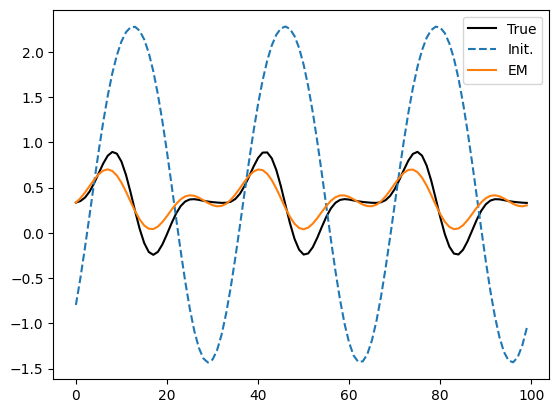

In [ ]:
params, _ = model2.fit_em(initial_params, true_params_props, emissions=Y, num_iters=100, verbose=True)

plt.plot(As.squeeze(), c='k', label='True')
plt.plot(initial_params.dynamics.weights.squeeze(), ls='--', label='Init.')
plt.plot(params.dynamics.weights.squeeze(), ls='-', label='EM')
plt.legend()
# print(params.dynamics.cov.shape)

#### 2d

In [37]:
# 2d example

# Constants
n_neurons = 4
latent_dim = 2
peaks = jnp.linspace(-jnp.pi, jnp.pi, n_neurons + 1)[:-1]  # tuning curve peaks
widths = 0.1 * jnp.ones(n_neurons)  # tuning curve widths
epsilon = 0.1
noise_scale = 0.05
T = 100

speed = 0.2
omega = jnp.ones(T) * speed
theta = jnp.cumsum(omega)
As_2d, _, _ = dynamics(theta, omega)
m0, S0 = initial_condition(theta[0], omega[0])

model2d = GPLDS(state_dim=latent_dim, emission_dim=n_neurons, input_dim=0, has_emissions_bias=False, has_dynamics_bias=False)
true_params_2d, true_params_props_2d = model2d.initialize(
    initial_mean=m0, 
    initial_covariance=S0, 
    dynamics_weights=As_2d,
    dynamics_covariance=(noise_scale**2) * jnp.eye(latent_dim),
    emission_weights=jxr.normal(jxr.PRNGKey(0), shape=(n_neurons, latent_dim)),
    emission_covariance=(noise_scale**2) * jnp.eye(n_neurons),
)

In [38]:
# Run the dynamics to get a batch of data
B = 100
# X, Y = [], []
# for i in tqdm(range(B), desc="Generating data 2d"):
#     xs, ys = model2d.sample(true_params_2d, jxr.PRNGKey(i), T)
#     X.append(xs)
#     Y.append(ys)

X, Y = jax.vmap(lambda i: model2d.sample(true_params_2d, jxr.PRNGKey(i), num_timesteps=T))(jnp.arange(B)) # inputs=theta.reshape(-1, 1)
X = jnp.stack(X)
Y = jnp.stack(Y)

print(X.shape, Y.shape)

(100, 100, 2) (100, 100, 4)


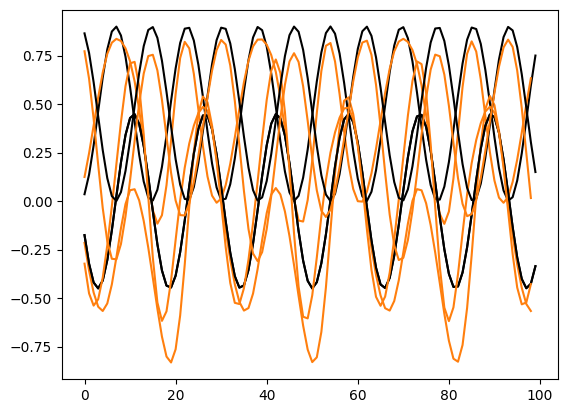

In [39]:
A_prior = WeightSpaceGP(0.5, 0.1, N=4, period=2*jnp.pi)

# EM 
initial_params_2d = make_lgssm_params(
    initial_mean=jnp.zeros(latent_dim),
    initial_cov=jnp.eye(latent_dim),
    dynamics_weights=A_prior.sample(jxr.PRNGKey(0), theta, D1=2, D2=2), #jnp.stack([A_prior.sample(jxr.PRNGKey(i+11), theta) for i in range(4)]).reshape(2,2,-1).T,
    dynamics_cov=((noise_scale/2)**2) * jnp.eye(latent_dim),
    emissions_weights=jxr.normal(jxr.PRNGKey(0), shape=(n_neurons, latent_dim)),
    emissions_cov=((noise_scale/2)**2)  * jnp.eye(n_neurons),
    # dynamics_input_weights=jnp.zeros((latent_dim, 1)),
    # emissions_input_weights=jnp.zeros((n_neurons, 1)),
)
model2d.A_prior = A_prior

# Repeat theta B times
inputs = jnp.tile(theta, (B, 1)).reshape(B, T, 1)
params, _ = model2d.fit_em(initial_params_2d, true_params_props_2d, emissions=Y, num_iters=20, verbose=True) # inputs=inputs,

for i in range(2):
    for j in range(2):
        plt.plot(As_2d[:,i,j], c='k', label=f'True {1}')
        # plt.plot(initial_params_2d.dynamics.weights[:,i,j], label=f'Initial {1}', ls='--', c='tab:blue')
        plt.plot(params.dynamics.weights[:,i,j], label=f'EM {i}', c='tab:orange')
# plt.plot(params.dynamics.weights[:,0,0])
# plt.plot(As_2d[:,0,0])

# Latent space

In [ ]:
f_prior = WSGaussianProcess(1.0, 0.1, N=10)
true_weights_seed = 0
key_x, key_y = jxr.split(jxr.PRNGKey(true_weights_seed), num=2)

T = 100
theta = jnp.cumsum(jnp.ones(T) * 0.03) % 1
xs = theta + 0.01 * jxr.normal(key_x, shape=(T,))
xs = xs % 1

ys = f_prior.sample(key_y, xs)
plt.plot(ys)

In [ ]:
# Assume uniform prior on xts 

S = 10
# x_samples = jxr.uniform(jxr.PRNGKey(0), shape=(S,T,))
x_samples = jnp.empty((S,T))
for i in range(S):
    _x_samples = theta + 0.1 * jxr.normal(jxr.PRNGKey(i), shape=(T,))
    x_samples = x_samples.at[i].set(_x_samples)
x_samples = x_samples % 1

# x_samples = jnp.repeat(xs[None], S, axis=0)
tilde_x = x_samples.flatten()

# Duplicate y samples for each x sample
y_samples = jnp.repeat(ys[None], S, axis=0)
tilde_y = y_samples.flatten()

# Compute the log likelihood of the data given the samples
Phi = evaluate_basis(f_prior.basis_funcs, tilde_x).T

# Compute MAP estimate of the weights
w_MAP = jnp.linalg.solve(Phi.T @ Phi + S * jnp.eye(len(f_prior.basis_funcs)), Phi.T @ tilde_y)
print(w_MAP)

# plt.plot(w_MAP)
# plt.plot(f_prior.weights(key_y))

plt.plot(jnp.linspace(0,1,100), f_prior.sample(key_y, jnp.linspace(0,1,100)), c='k')
plt.plot(jnp.linspace(0,1,100), w_MAP @ evaluate_basis(f_prior.basis_funcs, jnp.linspace(0,1,100)), c='tab:orange', ls='--', label='MAP')

In [ ]:
# Compute the log likelihood of the data given the samples
Phi = evaluate_basis(f_prior.basis_funcs, xs).T

# Compute MAP estimate of the weights
w_MAP = jnp.linalg.solve(Phi.T @ Phi + jnp.eye(len(f_prior.basis_funcs)), Phi.T @ ys)

plt.plot(w_MAP)
plt.plot(f_prior.weights(key_y))